Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([36]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([36, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing plate1.PNG...
Recognized License Plate Text: O1B335MW
Saved processed image to ../output_images/processed_plate1.PNG


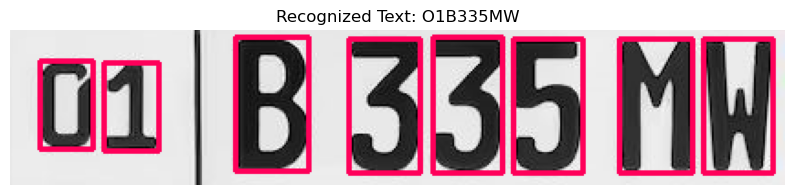

Processing plate2.PNG...
Recognized License Plate Text: MYKSMTO4
Saved processed image to ../output_images/processed_plate2.PNG


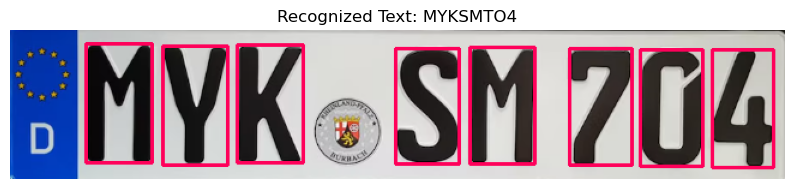

Processing plate3.PNG...
Recognized License Plate Text: 1B9S4BB
Saved processed image to ../output_images/processed_plate3.PNG


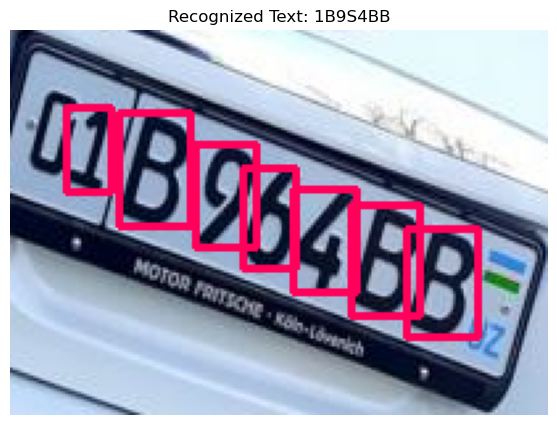

In [12]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification
from torchvision import transforms
from PIL import Image
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the trained Vision Transformer (ViT) model for character recognition
characterRecognition = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=36,  # Set to 36 to match the checkpoint
    ignore_mismatched_sizes=True
)
checkpoint = torch.load('../trained weight/vit_model.pth', weights_only=True)
characterRecognition.load_state_dict(checkpoint)  # Load the model state
characterRecognition.to(device)
characterRecognition.eval()

# Character mapping dictionary for 36 classes (0-9 and A-Z)
dictionary = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
              10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
              20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
              30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'}

# Define preprocessing transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

def VITCharRecognition(img):
    """Recognize a character using the ViT model."""
    img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = characterRecognition(img).logits
        predicted_idx = torch.argmax(outputs, dim=1).item()

    return dictionary[predicted_idx]

def auto_canny(image, sigma=0.33):
    """Apply Canny edge detection with automatic thresholds."""
    v = np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    return edged

def opencvReadPlate(img):
    charList = []
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh_inv = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 39, 1)
    edges = auto_canny(thresh_inv)
    ctrs, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
    img_area = img.shape[0] * img.shape[1]

    for i, ctr in enumerate(sorted_ctrs):
        x, y, w, h = cv2.boundingRect(ctr)
        roi_area = w * h
        non_max_sup = roi_area / img_area

        # Filter out non-character contours
        if (non_max_sup >= 0.015) and (non_max_sup < 0.09):
            if (h > 1.2 * w) and (3 * w >= h):
                # Recognize character
                char_img = img[y:y + h, x:x + w]
                char = VITCharRecognition(char_img)
                charList.append(char)
                cv2.rectangle(img, (x, y), (x + w, y + h), (90, 0, 255), 2)

    licensePlate = "".join(charList)
    return img, licensePlate  # Return processed image and recognized text

# Load and process test images
image_dir = "../test_data/"
image_files = ["plate1.PNG", "plate2.PNG", "plate3.PNG"]  # Add all your image filenames here

output_dir = "../output_images/"  # Directory to save the results
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Process each image
for image_file in image_files:
    # Construct the full path for the image
    image_path = os.path.join(image_dir, image_file)
    output_path = os.path.join(output_dir, f"processed_{image_file}")

    # Load the image
    plate_img = cv2.imread(image_path)

    if plate_img is not None:
        print(f"Processing {image_file}...")
        processed_img, license_text = opencvReadPlate(plate_img)
        print(f"Recognized License Plate Text: {license_text}")

        # Save the processed image
        cv2.imwrite(output_path, processed_img)
        print(f"Saved processed image to {output_path}")

        # Display the image with Matplotlib
        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Recognized Text: {license_text}")
        plt.axis('off')
        plt.show()
    else:
        print(f"Error: Could not load the image {image_file}.")
